In [14]:
import pandas as pd
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

In [4]:
file_path = "../data/magpie-sims-400k.csv"

In [5]:
TILE_DIST = {
    "A": 9, "B": 2, "C": 2, "D": 4, "E": 12, "F": 2, "G": 3, "H": 2, "I": 9,
    "J": 1, "K": 1, "L": 4, "M": 2, "N": 6, "O": 8, "P": 2, "Q": 1, "R": 6,
    "S": 4, "T": 6, "U": 4, "V": 2, "W": 2, "X": 1, "Y": 2, "Z": 1, "?": 2
}

BASE_LEAVE = {k: 0 for k in TILE_DIST.keys()}

### Data Ingestion + Feature Engineering

In [6]:
# Open the file and iterate through each line
cnt = 0
training_data = []

start_time = time.time()

with open(file_path, 'r') as file:
    for line in file:
        cnt += 1
#         if cnt > 10:
#             break
        # Strip the line of leading/trailing whitespace
        line = line.strip()
        
        # Split the line by spaces (or any other delimiter as needed)
        parts = line.split()
        
        board_state = parts[0]
        leave = parts[1].replace("/", "")
        opp_score, player_score = map(int, parts[2].split("/"))
        score_diff = player_score - opp_score
        _, winProb, expDiff = map(float, parts[3].split(","))
        
        unseen_tiles = dict(TILE_DIST)
        leave_dict = dict(BASE_LEAVE)
        
        for el in board_state:
            if not el.isalpha():
                continue
            if el.islower():
                unseen_tiles["?"] -= 1
            else:
                unseen_tiles[el] -= 1
        
        for el in leave:
            unseen_tiles[el] -= 1
            leave_dict[el] += 1
        
        leave_flattened = [leave_dict[letter] for letter in TILE_DIST.keys()]
        unseen_tiles_flattened = [unseen_tiles[letter] for letter in TILE_DIST.keys()]
        
        # Total number of unseen tiles remaining
        total_unseen_tiles = sum(unseen_tiles.values())
        
        # Create a row for this data point with columns for each letter
        row = {
            "score_diff": score_diff,
            "total_unseen_tiles": total_unseen_tiles,
            **{f"leave_{letter}": leave_dict[letter] for letter in TILE_DIST.keys()},
            **{f"unseen_{letter}": unseen_tiles[letter] for letter in TILE_DIST.keys()},
            "winProb": winProb,
            "expPointDiff": expDiff
        }
        
        # Append the row to the training data list
        training_data.append(row)
        
# Record the end time
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.4f} seconds")

Total execution time: 9.5904 seconds


In [9]:
df = pd.DataFrame(training_data)
print(len(df))


395715


### Training

In [13]:
# Step 1: Prepare the features (X) and the target (y)
X = df.drop(columns=['winProb', 'expPointDiff'])
y = df['winProb']  # Predicting win probability as a continuous value

# Step 2: Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
Best score (negative MSE): -0.001998151084126994
Training time: 151.5337 seconds
Test MSE: 0.0017
Test RMSE: 0.0415
Test R^2 Score: 0.9833


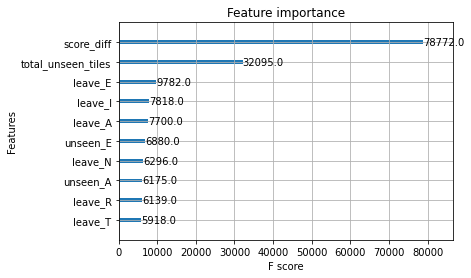

In [18]:
# Step 3: Set up the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 6, 9],
#     'n_estimators': [100, 200]
# }


# param_grid = {
#     'learning_rate': [0.1, 0.2, 0.3],  # Expanding the learning rate range
#     'max_depth': [9, 12, 15],  # Trying deeper trees
#     'n_estimators': [200, 300, 1000]  # Testing more estimators
# }

param_grid = {
    'learning_rate': [0.1],  # Expanding the learning rate range
    'max_depth': [9],  # Trying deeper trees
    'n_estimators': [1000, 2000, 3000]  # Testing more estimators
}

# Step 5: Perform grid search with 3-fold cross-validation using the training set
# Time the grid search process
start_time = time.time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Record the end time after training
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the best parameters and score from grid search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score (negative MSE): {grid_search.best_score_}")

# Print training time
print(f"Training time: {training_time:.4f} seconds")

# Step 6: Use the best model from grid search and evaluate on the test set
best_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate performance on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")

# Step 7: Visualize feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

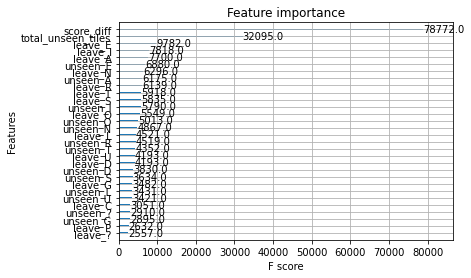

In [20]:
# Step 7: Visualize feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=30)

In [36]:
X_test_mod = X_test.copy()
X_test_mod["win_label"] = y_test
X_test_mod["win_pred"] = y_test_pred
X_test_mod["win_pred"] = X_test_mod["win_pred"].apply(lambda x: max(min(x, 1.0), 0))
X_test_mod["diff"] = (X_test_mod["win_pred"] - X_test_mod["win_label"]).apply(abs)

In [37]:
X_test_mod.head()

,score_diff,total_unseen_tiles,leave_A,leave_B,leave_C,leave_D,leave_E,leave_F,leave_G,leave_H,...,unseen_U,unseen_V,unseen_W,unseen_X,unseen_Y,unseen_Z,unseen_?,win_label,win_pred,diff
239196,-15,57,0,0,1,0,0,0,0,0,...,2,2,1,1,2,1,2,0.262472,0.257803,0.004669
252919,129,10,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0.999912,1.000000,0.000088
382401,-18,48,0,0,0,0,0,0,0,0,...,1,2,1,1,1,0,0,0.185308,0.204517,0.019209
216889,16,93,0,0,0,0,0,0,0,0,...,4,2,2,1,2,1,2,0.503322,0.497724,0.005598
330091,25,23,1,0,0,0,1,0,0,0,...,0,1,1,0,0,0,1,0.633751,0.629224,0.004527


In [40]:
X_test_mod["diff"].mean()

0.01374927776444378

In [41]:
# Sort by the 'diff' column to find rows with the largest differences
largest_diff_rows = X_test_mod.sort_values(by='diff', ascending=False)

# Display the top 10 rows with the largest differences
largest_diff_rows.head(10)

,score_diff,total_unseen_tiles,leave_A,leave_B,leave_C,leave_D,leave_E,leave_F,leave_G,leave_H,...,unseen_U,unseen_V,unseen_W,unseen_X,unseen_Y,unseen_Z,unseen_?,win_label,win_pred,diff
224982,0,4,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1.0,0.000000,1.000000
198368,-19,3,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1.0,0.002931,0.997069
312036,62,7,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1.0,0.009753,0.990247
258166,8,7,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1.0,0.013120,0.986880
258167,8,7,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1.0,0.013120,0.986880
54046,9,3,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.0,0.981210,0.981210
169168,15,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.022727,0.977273
349225,48,7,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,1.0,0.041707,0.958293
181743,-6,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.058621,0.941379
87647,17,5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1.0,0.070445,0.929555


In [49]:
import pandas as pd

# Step 1: Define the bins for score_diff and total_unseen_tiles
score_diff_bins = pd.cut(X_test_mod['score_diff'], bins=5)
unseen_tiles_bins = pd.cut(X_test_mod['total_unseen_tiles'], bins=5)

# Step 2: Assign the labels with the range of values for each bin
X_test_mod['score_diff_bucket'] = score_diff_bins.apply(lambda x: f'{x.left:.2f} to {x.right:.2f}')
X_test_mod['unseen_tiles_bucket'] = unseen_tiles_bins.apply(lambda x: f'{x.left:.2f} to {x.right:.2f}')

# Step 3: Compute the average, count, and standard deviation of 'diff' for each combination of 'score_diff_bucket' and 'unseen_tiles_bucket'
bucket_stats = X_test_mod.groupby(['score_diff_bucket', 'unseen_tiles_bucket']).agg(
    avg_diff=('diff', 'mean'),
    count=('diff', 'count'),
    std_diff=('diff', 'std')
).reset_index()

# Step 4: Reexpress the avg_diff as a percentage
bucket_stats['avg_diff'] = bucket_stats['avg_diff'] * 100  # Convert to percentage
bucket_stats['std_diff'] = bucket_stats['std_diff'] * 100  # Convert to percentage

# Step 5: Display the updated stats
print(bucket_stats.sort_values(by='avg_diff', ascending=False))


     score_diff_bucket unseen_tiles_bucket  avg_diff  count  std_diff
10     -73.80 to 86.80       0.90 to 20.80  3.806072  12314  8.899929
11     -73.80 to 86.80      20.80 to 40.60  1.476116  10778  1.537095
12     -73.80 to 86.80      40.60 to 60.40  1.128660  11827  1.106034
13     -73.80 to 86.80      60.40 to 80.20  0.981236  12975  0.920465
15     86.80 to 247.40       0.90 to 20.80  0.937603   4113  3.687135
14     -73.80 to 86.80     80.20 to 100.00  0.779352  12000  0.715138
18     86.80 to 247.40      60.40 to 80.20  0.676018    883  0.634090
16     86.80 to 247.40      20.80 to 40.60  0.639048   2261  0.736967
17     86.80 to 247.40      40.60 to 60.40  0.619070   1605  0.626980
19     86.80 to 247.40     80.20 to 100.00  0.610257    108  0.638513
9    -234.40 to -73.80     80.20 to 100.00  0.513575     93  0.434509
8    -234.40 to -73.80      60.40 to 80.20  0.449573   1057  0.428619
7    -234.40 to -73.80      40.60 to 60.40  0.422055   1663  0.471206
6    -234.40 to -73.

In [50]:
import pandas as pd

# Step 1: Define custom bins for total_unseen_tiles with ranges of 10
unseen_tiles_bins = pd.cut(X_test_mod['total_unseen_tiles'], bins=range(0, X_test_mod['total_unseen_tiles'].max() + 10, 10))

# Step 2: Assign the labels with the range of values for each bin
X_test_mod['unseen_tiles_bucket'] = unseen_tiles_bins.apply(lambda x: f'{int(x.left)} to {int(x.right)}')

# Step 3: Compute the average, count, and standard deviation of 'diff' for each unseen_tiles_bucket
bucket_stats = X_test_mod.groupby('unseen_tiles_bucket').agg(
    avg_diff=('diff', 'mean'),
    count=('diff', 'count'),
    std_diff=('diff', 'std')
).reset_index()

# Step 4: Reexpress the avg_diff and std_diff as percentages
bucket_stats['avg_diff'] = bucket_stats['avg_diff'] * 100  # Convert to percentage
bucket_stats['std_diff'] = bucket_stats['std_diff'] * 100  # Convert to percentage

# Step 5: Display the updated stats, sorted by avg_diff
print(bucket_stats.sort_values(by='avg_diff', ascending=False))


  unseen_tiles_bucket  avg_diff  count  std_diff
0             0 to 10  2.758477  13165  8.828005
1            10 to 20  1.976087   7979  2.760023
2            20 to 30  1.230496   7793  1.537706
3            30 to 40  1.105743   7985  1.236880
4            40 to 50  1.036342   7758  1.093231
5            50 to 60  0.953484   7347  0.987375
6            60 to 70  0.947832   7626  0.922167
7            70 to 80  0.902112   7289  0.859471
8            80 to 90  0.886929   7939  0.791443
9           90 to 100  0.568880   4262  0.473250


In [53]:
X_test_mod_sans_end_game = X_test_mod[X_test_mod.total_unseen_tiles >= 20]

In [54]:
X_test_mod_sans_end_game

,score_diff,total_unseen_tiles,leave_A,leave_B,leave_C,leave_D,leave_E,leave_F,leave_G,leave_H,...,unseen_W,unseen_X,unseen_Y,unseen_Z,unseen_?,win_label,win_pred,diff,score_diff_bucket,unseen_tiles_bucket
239196,-15,57,0,0,1,0,0,0,0,0,...,1,1,2,1,2,0.262472,0.257803,0.004669,-73.80 to 86.80,50 to 60
382401,-18,48,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0.185308,0.204517,0.019209,-73.80 to 86.80,40 to 50
216889,16,93,0,0,0,0,0,0,0,0,...,2,1,2,1,2,0.503322,0.497724,0.005598,-73.80 to 86.80,90 to 100
330091,25,23,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0.633751,0.629224,0.004527,-73.80 to 86.80,20 to 30
274261,-80,68,1,1,0,0,0,0,0,0,...,2,0,1,0,2,0.111518,0.122717,0.011199,-234.40 to -73.80,60 to 70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297337,38,93,0,0,0,0,1,0,0,0,...,2,0,2,1,1,0.571313,0.561265,0.010048,-73.80 to 86.80,90 to 100
103503,-17,27,0,0,0,0,2,0,0,0,...,0,1,0,1,1,0.226349,0.208476,0.017873,-73.80 to 86.80,20 to 30
71639,8,40,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0.421238,0.435194,0.013956,-73.80 to 86.80,30 to 40
10448,9,90,1,0,0,0,0,0,0,0,...,1,1,2,0,2,0.446048,0.443765,0.002283,-73.80 to 86.80,80 to 90


In [55]:
test_mse = mean_squared_error(X_test_mod_sans_end_game["win_label"], X_test_mod_sans_end_game["win_pred"])
test_rmse = test_mse ** 0.5
test_r2 = r2_score(X_test_mod_sans_end_game["win_label"], X_test_mod_sans_end_game["win_pred"])

print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")

Test MSE: 0.0002
Test RMSE: 0.0146
Test R^2 Score: 0.9969


In [56]:
# Sort by the 'diff' column to find rows with the largest differences
largest_diff_rows = X_test_mod_sans_end_game.sort_values(by='diff', ascending=False)

# Display the top 10 rows with the largest differences
largest_diff_rows.head(10)

,score_diff,total_unseen_tiles,leave_A,leave_B,leave_C,leave_D,leave_E,leave_F,leave_G,leave_H,...,unseen_W,unseen_X,unseen_Y,unseen_Z,unseen_?,win_label,win_pred,diff,score_diff_bucket,unseen_tiles_bucket
155217,16,26,0,0,1,0,0,0,0,0,...,1,0,2,0,0,0.293303,0.559258,0.265955,-73.80 to 86.80,20 to 30
215051,16,22,0,0,0,0,0,0,0,0,...,0,0,2,0,1,0.294739,0.476640,0.181901,-73.80 to 86.80,20 to 30
100746,-7,23,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0.581520,0.401044,0.180476,-73.80 to 86.80,20 to 30
304239,31,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.851034,0.672843,0.178191,-73.80 to 86.80,20 to 30
7384,-18,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.716669,0.545176,0.171493,-73.80 to 86.80,20 to 30
41923,45,22,1,1,0,0,1,0,0,0,...,1,0,0,0,1,0.852854,0.692644,0.160210,-73.80 to 86.80,20 to 30
179219,14,20,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0.827451,0.668736,0.158715,-73.80 to 86.80,10 to 20
205877,2,22,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0.715336,0.565815,0.149521,-73.80 to 86.80,20 to 30
44711,22,41,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0.364268,0.510598,0.146330,-73.80 to 86.80,40 to 50
32319,-15,31,0,0,1,1,1,0,0,0,...,1,1,0,0,0,0.692851,0.550079,0.142772,-73.80 to 86.80,30 to 40
